In [1]:
import os

import yaml
from mdsetup import MDSetup
from mdsetup.analysis.umbrella_sampling import (
    create_index_file,
    find_frames,
    gmx_wham_analysis,
)

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

********* JAX NOT FOUND *********
 PyMBAR can run faster with JAX  
 But will work fine without it   
Either install with pip or conda:
      pip install pybar[jax]     
               OR                
      conda install pymbar       
*********************************


## Umbrella sampling

This notebook uses MDSetup to setup simulations to compute a free energy difference using umbrella sampling

In [2]:
gromacs_setup = MDSetup(
    system_setup="input/setup_us.yaml",
    simulation_default="input/defaults.yaml",
    simulation_ensemble="input/ensemble.yaml",
    submission_command="qsub",
)

MD input will be generated for 'gromacs'!


### Equilibrate system

In this section the inital system is equilibrated at desired temperature and pressure.

1) Setup simulation

In [ ]:
# Define the simulation folder
simulation_folder = "free_energy/equilibration"

# Define the ensembles that should be simulated (definition what each ensemble means is provided in yaml file)
ensembles = ["em", "npt_equilibration"]

# Define the simulation time per ensemble in nano seconds
simulation_times = [50000, 0.1]

# Define initial systems, in case the simulation should be continued from a prior simulation.
# In that case, provide one initial structure for each temperature & pressure state.
# If the simulation should start from an initial configuration, provide an empty list.
initial_systems = ["input/solv_ions.gro"] * 2

# Provide kwargs that should be passed into the input template directly
input_kwargs = {}

# Define number of copies
copies = 0

# Define the starting number for the first ensemble ( 0{off_set}_ensemble )
off_set = 0

# In case templates for job submission or any other templates are edited
# Any keyword argument can be passed to this function call
gromacs_setup.prepare_simulation(
    folder_name=simulation_folder,
    ensembles=ensembles,
    simulation_times=simulation_times,
    initial_systems=initial_systems,
    input_kwargs=input_kwargs,
    copies=copies,
    off_set=off_set,
)

2) Submit jobs to cluster

In [ ]:
# Submit the simulations
gromacs_setup.submit_simulation()

### Run steered MD simulations

Create index file with groups that should be constrained

In [ ]:
# Define umbrella sampling settings
with open("input/umbrella_sampling.yaml") as f:
    umbrella_sampling = yaml.safe_load(f)

# Get index file
template_index = "../../templates/bash/create_index_pbs.sh"
structure = "input/solv_ions.gro"
index_file = gromacs_setup.project_folder + "/free_energy/index.ndx"
index_file = create_index_file(
    template_index,
    structure,
    index_file,
    [grp["selection"] for grp in umbrella_sampling["groups"]],
    [grp["name"] for grp in umbrella_sampling["groups"]],
)

# For this example change the define constraint
gromacs_setup.simulation_default["system"]["define"] = "-DPOSRES_B"

In [ ]:
# Define simulation folder
simulation_folder = "free_energy/equilibration"

# Define the ensembles that should be simulated
ensembles = ["steered_md"]

# Define pull velocity for steered MD
umbrella_sampling["pull_coord1_rate"] = 0.01

# Define the simulation time per ensemble in nano seconds
simulation_times = [0.5]

# Define number of copies
copies = 0

# Define the starting number for the first ensemble ( 0{off_set}_ensemble )
off_set = 2

# Get initial systems from equilibration
initial_systems = [
    (
        f"{gromacs_setup.project_folder}/{simulation_folder}/{state}"
        "/copy_0/01_npt_equilibration/npt_equilibration.gro"
    )
    for state in gromacs_setup.define_state_cond_list()
]

gromacs_setup.prepare_simulation(
    folder_name=simulation_folder,
    ensembles=ensembles,
    simulation_times=simulation_times,
    initial_systems=initial_systems,
    input_kwargs={"umbrella_sampling": umbrella_sampling, "index_file": index_file},
    copies=copies,
    off_set=off_set,
)

2) Submit jobs to cluster

In [ ]:
# Submit the simulations
gromacs_setup.submit_simulation()

Analyse steered MD and choose initial systems for umbrella sampling

In [ ]:
# Define umbrella sampling settings
with open("input/umbrella_sampling.yaml") as f:
    umbrella_sampling = yaml.safe_load(f)

simulation_folder = "free_energy/equilibration"
template_frames = "../../templates/bash/get_cv.sh"
index_file = gromacs_setup.project_folder + "/free_energy/index.ndx"

initial_systems = []
for state in gromacs_setup.define_state_cond_list():
    trajectory_folder = (
        f"{gromacs_setup.project_folder}/{simulation_folder}/{state}/copy_0/"
        "02_steered_md"
    )

    initial_systems.append(
        find_frames(
            template_frames,
            trajectory_folder,
            index_file,
            **umbrella_sampling["cv"],
            show_histogram=True,
        )
    )

# Restructure initial systems to shape (cv, state) rather than (state, cv)
initial_systems = list(map(list, zip(*initial_systems)))

### Run umbrella sampling simulations

In [ ]:
# Define the ensembles that should be simulated
ensembles = ["em", "npt_equilibration", "npt_production"]

# Define the simulation time per ensemble in nano seconds
simulation_times = [10000, 0.1, 1.0]

# Remove pull velocity for umbrella sampling
umbrella_sampling["pull_coord1_rate"] = 0.0

umbrella_sampling["pull-pbc-ref-prev-step-com"] = "yes"
umbrella_sampling["pull-group1-pbcatom"] = 113
umbrella_sampling["pull-group2-pbcatom"] = 339

# Define number of copies
copies = 0

# Define the starting number for the first ensemble ( 0{off_set}_ensemble )
off_set = 0

# Ensure that all jobs for all solutes and all lambdas are submitted at once
job_files = [[] for _ in gromacs_setup.system_setup["temperature"]]

for i, _ in enumerate(initial_systems):
    # Define simulation folder for each lambda
    sim_folder = f"free_energy/umbrella_sampling/umbrella_{i}"

    gromacs_setup.prepare_simulation(
        folder_name=sim_folder,
        ensembles=ensembles,
        simulation_times=simulation_times,
        initial_systems=initial_systems[i],
        input_kwargs={"umbrella_sampling": umbrella_sampling, "index_file": index_file},
        copies=copies,
        off_set=off_set,
    )

    for j, files in enumerate(gromacs_setup.job_files):
        job_files[j].extend(files)

gromacs_setup.job_files = job_files

2) Submit jobs to cluster

In [ ]:
# Submit the simulations
gromacs_setup.submit_simulation()

### Analyse umbrella sampling simulations

In [3]:
# Use GROMACS WHAM analysis script (alternative pyMBAR, can be implemented if necessary:
# https://github.com/choderalab/pymbar/tree/master/examples/umbrella-sampling-fes)

# Define umbrella sampling settings
with open("input/umbrella_sampling.yaml") as f:
    umbrella_sampling = yaml.safe_load(f)


ensemble = "02_npt_production"
ensemble_name = "_".join(ensemble.split("_")[1:])

sim_folder = f"{gromacs_setup.project_folder}/free_energy/umbrella_sampling"
analysis_folder = f"{sim_folder}/analysis"
os.makedirs(f"{sim_folder}/analysis/", exist_ok=True)

wham_template = "../../templates/bash/wham_analysis.sh"


Perform WHAM locally! Wait until it is finished.



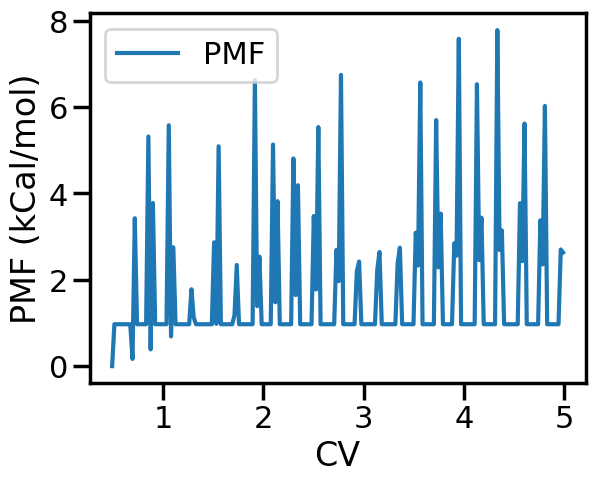

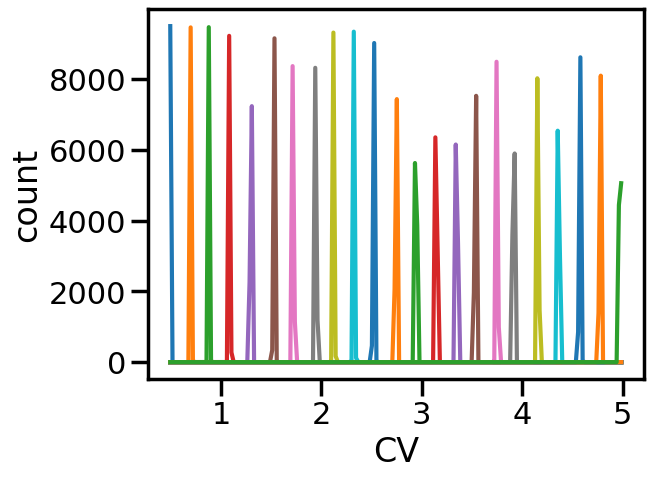


Perform WHAM locally! Wait until it is finished.



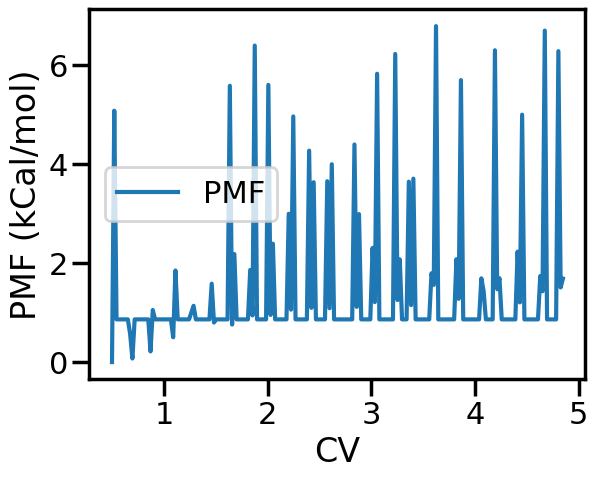

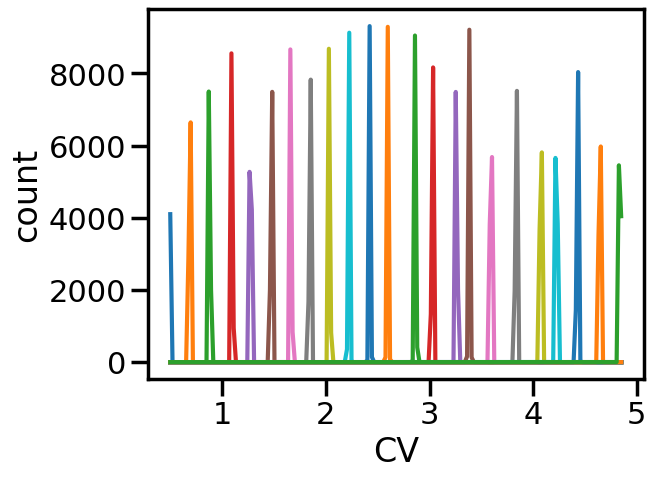

In [4]:
pmf_dataframes = []

for state in gromacs_setup.loop_through_states():
    print(f"Analyzing: {gromacs_setup.define_state_text(**state)}")

    state_condition = gromacs_setup.define_state_cond(**state)

    tpr_file = f"{analysis_folder}/{state_condition}_trp.dat"
    pullx_file = f"{analysis_folder}/{state_condition}_pullx.dat"

    with open(tpr_file, "w") as f:
        f.write(
            "\n".join(
                [
                    f"{sim_folder}/umbrella_{i}/{state_condition}/copy_0/{ensemble}/{ensemble_name}.tpr"
                    for i in range(umbrella_sampling["cv"]["num_frames"])
                ]
            )
        )
    with open(pullx_file, "w") as f:
        f.write(
            "\n".join(
                [
                    f"{sim_folder}/umbrella_{i}/{state_condition}/copy_0/{ensemble}/{ensemble_name}_pullx.xvg"
                    for i in range(umbrella_sampling["cv"]["num_frames"])
                ]
            )
        )

    pmf_dataframes.append(
        gmx_wham_analysis(
            wham_template,
            state["temperature"],
            analysis_folder,
            tpr_file,
            pullx_file,
            state_condition,
        )
    )

There is the Possibility to simply add more umbrellas. Just choose a corresponding starting frame and add the simulations on top of the already runned. Then just include this simulation in the tpr / pullx file.